# Simple demo of PIICM

Leiv Rønneberg, July 2023



## Introduction

PIICM is a probabilistic framework for dose-response prediction of drug combination in cancer. In this notebook, a short demonstration is given of the model, and how it is used to predict dose-response in unperformed experiments.

At its core, the model is a simple variation of the classic Intrinsic Coregionalisation Model from spatial statistics, but is tailored to dose-response prediction in two major ways:
1. The model is made invariant to a certain permutation of its inputs through its prior, and
2. the model weights observations according to experimental quality through its likelihood.

Making use of efficient Kronecker structure of the kernel matrices, the PIICM is able to learn from noisy and sparsely observed datasets and accurately predict dose-response in held out experiments.

## Background

In-vitro drug combination experiments are performed on cancer cell lines in order to find novel treatments and to study drug interaction. These experiments are performed using many drugs, in different concentrations and tested on many different cancer cell lines, producing large datasets.

For a given drug concentration $\mathbf{x}=(x_1,x_2)$ where $x_i$ denotes the drug concentration of the $i$th drug, the dose-response function $f:\mathbb{R}^2 \to [0,1]$ maps drug concentrations to a measure of cell viability (zero indicating all cells are dead, and one that all cells are still alive).

In drug-combination datasets, $f$ is frequently decomposed as 
$$
f(\mathbf{x})=p_0(\mathbf{x})+\Delta(\mathbf{x}),
$$
where $p_0(\mathbf{x})$ denotes a non-interaction assumption and $\Delta$ the drug interaction. The non-interaction assumption is assumed known for all drug combinations prior to modelling, and hence predicting the dose-response function amounts to predicting 



As input, the model needs:

1. a matrix of drug concentrations $\mathbf{X}\in\mathbb{R}^{n \times 2}$, where each row corresponds to a unique concentrations pair,
2. a matrix of responses $\mathbf{Y}\in\mathbb{R}^{n \times m}$, where $m$ denotes the number of outputs in the training dataset, and
3. a matrix of corresponding noise terms $\mathbf{S}\in\mathbb{R}^{n \times m}$.




## Setting up the model

In [1]:
# Initial imports
import math
import torch
import gpytorch
import numpy as np
import pandas as pd

In [27]:
# Set some constants
N_combinations = 50
N_cellLines = 39
# Reading in the data
X = torch.tensor(pd.read_csv("data/ONeil_concentrations.csv").values).float()
Y = torch.tensor(pd.read_csv("data/ONeil_GP_subset.csv").values).float()
S = torch.tensor(pd.read_csv("data/ONeil_noise_subset.csv").values).float()

In [28]:
# Do some reshaping to get the data in the correct format
n, p = Y.shape
p = 2*p
tmp = torch.full([n,p],float('nan'))
tmp_noise = torch.full([n,p],float('nan'))
for i in range(N_cellLines):
            orig = Y[:,(i*N_combinations):(i*N_combinations+N_combinations)]
            orig_noise = S[:,(i*N_combinations):(i*N_combinations+N_combinations)]
            new = torch.full(orig.shape,float('nan'))
            new_noise = torch.full(orig.shape,float('nan'))
            combined = torch.cat([orig,new],-1)
            combined_noise = torch.cat([orig_noise,new_noise],-1)
            tmp[:,(i*(2*N_combinations)):(i*(2*N_combinations)+2*N_combinations)] = combined
            tmp_noise[:,(i*(2*N_combinations)):(i*(2*N_combinations)+2*N_combinations)] = combined_noise
Y = tmp
S = tmp_noise
# Fill in missing values with dummy variables and mask
# Pad with missing values and large noise
mVAL = -999
mVAR = 99999999999999
missing_idx = Y.isnan()
N_missing = missing_idx.sum()
# Train output is given a fixed dummy values
Y = Y.masked_fill(missing_idx, mVAL)
# Correspondingly these are given a large noise
S = S.masked_fill(missing_idx, mVAR)

In [75]:
# Define some constants
N_tasks = int(2 * N_combinations * N_cellLines)
N_total = Y.numel()
N_obs = int(N_total - N_missing)
drugRank = 25
cellRank = 20
symmetric = True
maxiter=200
tol=1e-3
cg_tol=0.01
eval_cg_tol=0.01

In [76]:
# Here now set up the model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=N_tasks
        )
        self.covar_module = gpytorch.kernels.DrugResponseKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            num_combinations=N_combinations, num_cell_lines=N_cellLines,
            drug_rank=drugRank, cell_linerank=cellRank,
            symmetric=symmetric
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.FixedNoiseMultitaskGaussianLikelihood(num_tasks=N_tasks,
                                                                        noise=S)
model = MultitaskGPModel(X, Y, likelihood)

In [77]:
# Training
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
# Keeping track of loss
m = []
diff = 10
with gpytorch.settings.verbose_linalg(True), gpytorch.settings.max_preconditioner_size(0):
    with gpytorch.settings.use_eigvalsh(True), gpytorch.settings.max_cg_iterations(2000):
        with gpytorch.settings.cg_tolerance(cg_tol):
            for i in range(maxiter):
                optimizer.zero_grad()
                output = model(X)
                loss = -mll(output, Y)
                loss.backward()
                optimizer.step()
                m.append(loss.item())
                if i > 0:
                    diff = abs(m[i] - m[i - 1])
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  loss difference: %.4f' % (
                    i + 1, maxiter, loss.item(),
                    model.covar_module.data_covar_module.base_kernel.lengthscale.item(),
                    model.likelihood.global_noise.item(),
                    diff
                ))
                if diff < tol:
                    print('Model converged!')
                    break

LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 27 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 1/200 - Loss: 0.974   lengthscale: 0.644   noise: 0.644  loss difference: 10.0000


LinAlg (Verbose) - DEBUG - CG converged after 67 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 2/200 - Loss: 0.965   lengthscale: 0.598   noise: 0.598  loss difference: 0.0090


LinAlg (Verbose) - DEBUG - CG converged after 100 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 3/200 - Loss: 0.958   lengthscale: 0.554   noise: 0.555  loss difference: 0.0065


LinAlg (Verbose) - DEBUG - CG converged after 126 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 4/200 - Loss: 0.953   lengthscale: 0.513   noise: 0.513  loss difference: 0.0054


LinAlg (Verbose) - DEBUG - CG converged after 147 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 5/200 - Loss: 0.948   lengthscale: 0.474   noise: 0.475  loss difference: 0.0045


LinAlg (Verbose) - DEBUG - CG converged after 161 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 6/200 - Loss: 0.944   lengthscale: 0.438   noise: 0.438  loss difference: 0.0041


LinAlg (Verbose) - DEBUG - CG converged after 171 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 7/200 - Loss: 0.940   lengthscale: 0.403   noise: 0.404  loss difference: 0.0038


LinAlg (Verbose) - DEBUG - CG converged after 174 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 8/200 - Loss: 0.937   lengthscale: 0.372   noise: 0.373  loss difference: 0.0036


LinAlg (Verbose) - DEBUG - CG converged after 176 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 9/200 - Loss: 0.933   lengthscale: 0.342   noise: 0.343  loss difference: 0.0034


LinAlg (Verbose) - DEBUG - CG converged after 171 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 10/200 - Loss: 0.930   lengthscale: 0.315   noise: 0.316  loss difference: 0.0032


LinAlg (Verbose) - DEBUG - CG converged after 165 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 11/200 - Loss: 0.927   lengthscale: 0.291   noise: 0.291  loss difference: 0.0029


LinAlg (Verbose) - DEBUG - CG converged after 161 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 12/200 - Loss: 0.925   lengthscale: 0.269   noise: 0.268  loss difference: 0.0025


LinAlg (Verbose) - DEBUG - CG converged after 159 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 13/200 - Loss: 0.922   lengthscale: 0.250   noise: 0.247  loss difference: 0.0022


LinAlg (Verbose) - DEBUG - CG converged after 157 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 14/200 - Loss: 0.920   lengthscale: 0.234   noise: 0.228  loss difference: 0.0019


LinAlg (Verbose) - DEBUG - CG converged after 152 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 15/200 - Loss: 0.919   lengthscale: 0.221   noise: 0.210  loss difference: 0.0017


LinAlg (Verbose) - DEBUG - CG converged after 146 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 16/200 - Loss: 0.917   lengthscale: 0.211   noise: 0.194  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 141 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 17/200 - Loss: 0.916   lengthscale: 0.204   noise: 0.179  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 136 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 18/200 - Loss: 0.914   lengthscale: 0.200   noise: 0.166  loss difference: 0.0018


LinAlg (Verbose) - DEBUG - CG converged after 131 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 19/200 - Loss: 0.912   lengthscale: 0.199   noise: 0.154  loss difference: 0.0022


LinAlg (Verbose) - DEBUG - CG converged after 124 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 20/200 - Loss: 0.909   lengthscale: 0.199   noise: 0.143  loss difference: 0.0026


LinAlg (Verbose) - DEBUG - CG converged after 116 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 21/200 - Loss: 0.906   lengthscale: 0.202   noise: 0.133  loss difference: 0.0028


LinAlg (Verbose) - DEBUG - CG converged after 110 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 22/200 - Loss: 0.903   lengthscale: 0.206   noise: 0.124  loss difference: 0.0028


LinAlg (Verbose) - DEBUG - CG converged after 104 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 23/200 - Loss: 0.901   lengthscale: 0.212   noise: 0.116  loss difference: 0.0027


LinAlg (Verbose) - DEBUG - CG converged after 98 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 24/200 - Loss: 0.898   lengthscale: 0.218   noise: 0.108  loss difference: 0.0026


LinAlg (Verbose) - DEBUG - CG converged after 90 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 25/200 - Loss: 0.896   lengthscale: 0.225   noise: 0.101  loss difference: 0.0023


LinAlg (Verbose) - DEBUG - CG converged after 83 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 26/200 - Loss: 0.894   lengthscale: 0.232   noise: 0.095  loss difference: 0.0021


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 76 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 27/200 - Loss: 0.892   lengthscale: 0.239   noise: 0.090  loss difference: 0.0019


LinAlg (Verbose) - DEBUG - CG converged after 68 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 28/200 - Loss: 0.890   lengthscale: 0.245   noise: 0.085  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - CG converged after 65 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([390000, 1]).


computing log-det with Weyl's inequality!
390000
Iter 29/200 - Loss: 0.889   lengthscale: 0.250   noise: 0.080  loss difference: 0.0013


LinAlg (Verbose) - DEBUG - CG converged after 61 iterations.
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([39, 39]).
LinAlg (Verbose) - DEBUG - Running symeig on a SumPermutationLazyTensor of size torch.Size([100, 100]). Assumed Hermitian. Not clamping eigenvalues to zero


computing log-det with Weyl's inequality!
390000
Iter 30/200 - Loss: 0.888   lengthscale: 0.254   noise: 0.076  loss difference: 0.0010
Model converged!


In [78]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.max_cg_iterations(4000), gpytorch.settings.eval_cg_tolerance(eval_cg_tol), gpytorch.settings.verbose_linalg(True), gpytorch.settings.skip_posterior_variances(True):
    predictions = likelihood(model(X))
    mean = predictions.mean

if symmetric:
    n,p = mean.shape
    p = int(p/2)
    tmp = torch.full([n,p], float('nan'))
    for i in range(N_cellLines):
        tmp[:,(i*N_combinations):(i*N_combinations+N_combinations)] = mean[:,(i*(2*N_combinations)):(i*(2*N_combinations)+N_combinations)]
    mean = tmp

/Users/leiv/Dropbox/PIICM/gpytorch/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([390000, 1]) RHS for 4000 iterations (tol=0.01). Output: torch.Size([390000, 1]).
LinAlg (Verbose) - DEBUG - CG converged after 61 iterations.


## Plotting

In [79]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt

In [80]:
[Xt,Yt] = np.meshgrid(X[:,0].unique().numpy(),X[:,1].unique().numpy())

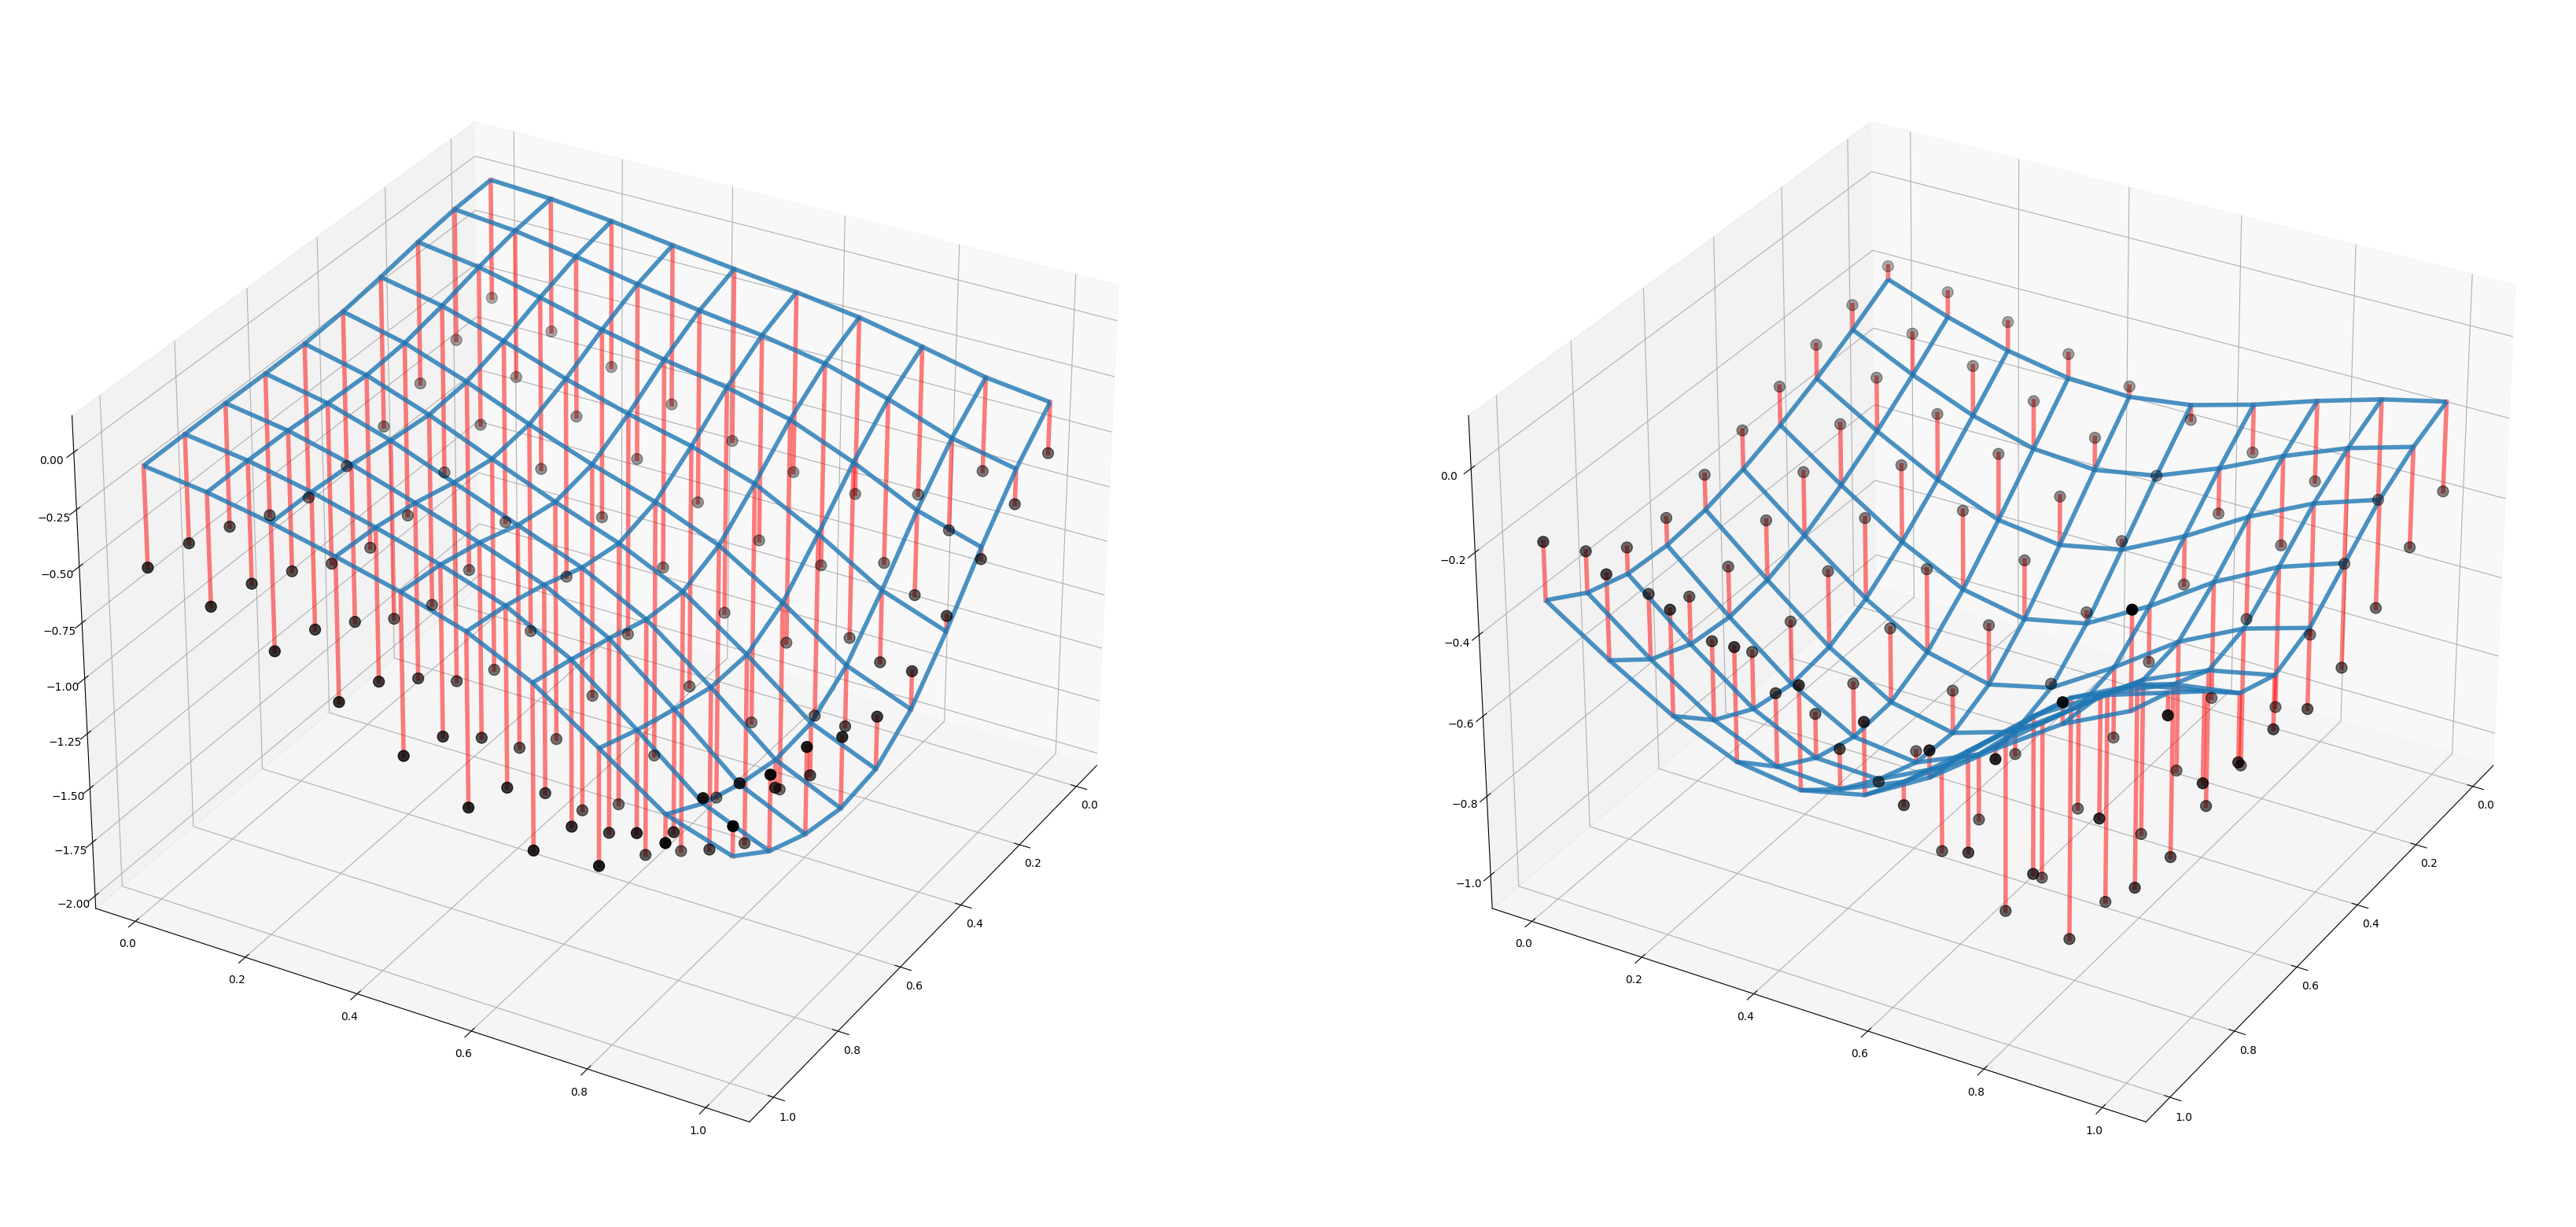

In [105]:
# Plotting for two tasks
task1 = 101
task2 = 1745
%matplotlib inline 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(42,20))


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])



ax1 = fig.add_subplot(1,2,1, projection="3d")
# Add surface
ax1.plot_wireframe(X=Xt,Y=Yt,Z=mean[:,task1].reshape(Xt.shape).detach().numpy(),cmap=plt.get_cmap('viridis'), alpha=0.8, linewidth=4 )
# Add points
ax1.scatter(Xt,Yt,Y[:,task1],c='k',s=100)
ax1.view_init(azim=30,elev=30)
# Add lines connecting each point to the surface
for kk in range(X.shape[0]):
    ax1.plot([X[kk,0],X[kk,0]],[X[kk,1],X[kk,1]],[mean[kk,task1],Y[kk,task1]],color="red",alpha=0.5,linewidth=4)

    
# Latent GP
ax2 = fig.add_subplot(1,2,2, projection="3d")

# Add surface
ax2.plot_wireframe(X=Xt,Y=Yt,Z=mean[:,task2].reshape(Xt.shape).detach().numpy(),cmap=plt.get_cmap('viridis'), alpha=0.8, linewidth=4 )
# Add points
ax2.scatter(Xt,Yt,Y[:,task2],c='k',s=100)
ax2.view_init(azim=30,elev=30)
# Add lines connecting each point to the surface
for kk in range(X.shape[0]):
    ax2.plot([X[kk,0],X[kk,0]],[X[kk,1],X[kk,1]],[mean[kk,task2],Y[kk,task2]],color="red",alpha=0.5, linewidth=4)
# Title